In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Méthode des moindres carrés

Afin de fixer les coefficients, nous définissons une mesure qui nous permet de connaître de façon empirique la qualité de l'ajustement.


Quelques constats :
1. Aucune droite ne peut passer par tous les points, vu qu'ils ne sont pas alignés
1. Chaque droite passe plus près de certains que d'autres
1. Nous décrétons pour le moment que la meilleure droite est celle qui passe le plus près de l'ensemble des points

Pour chaque x, nous allons calculer la distance cumulée entre $y_i$ projeté sur la droite à l'abscisse $x_i$, et minimiser cette quantité

$$Erreur(\theta) = \frac{1}{N}\sum_i (y_i-f_{\theta}(x_i))^2$$

* Les erreurs s'ajoutent toujours
* Pénalité sur les déviations les plus larges
* La fonction carré est dérivable

Nous souhaitons $\hat \theta$ tq $Erreur(\theta) \ge Erreur(\hat \theta)$

#### Résolution mathématique

Nous souhaitons minimiser le terme d'erreur, et donc trouver pour quelles valeurs de $\theta$ la dérivée s'annule
$$\frac{\partial E}{\partial \theta_i} = 0$$

pour la fonction $f_{\theta}(x) = \theta_0 + \theta_1 x +\epsilon $

On obtient les équations suivantes pour les paramètres (un très bon exercice à faire) 

$$\sum_i x_i (y_i-\theta_0-\theta_1 x_i) = 0  $$
$$\sum_i (y_i-\theta_0-\theta_1 x_i) = 0  $$


Il est possible dans le cadre de ce modèle d'avoir la solution exacte :

$$\hat  \theta_1 = \frac{\sum(x_i-\bar x)(y_i-\bar y)}{\sum (x_i - \bar x)^2} = \frac{cov(x,y)}{var(x)}$$
$$\hat \theta_0 = \bar y - \hat \theta_1 \bar x$$


#### Commençons par définir quelques fonctions

In [54]:
def linear(x, params=(0,1), var=1):
    """Generate a linear function f(x)=a*x+b+N(0,1)
    
    Args:
        x (numpy.array()) : vector used to generate the output
        params (tuple of size 2) : b=params[0] and a=params[1]
    
    Returns:
        numpy.array()
    """
    a, b = params[1], params[0]
    return b+a*x+var*np.random.normal(size=len(x))

In [55]:
x = 10*np.random.random(50)
y = linear(x, (1,3))

In [56]:
def linear_hypothesis(x, params=(0,1)):
    """Linear function f(x)=a*x+b
    
    Args:
        x (numpy.array()) : vector used to generate the output
        params (tuple of size 2) : b=params[0] and a=params[1]
    
    Returns:
        numpy.array()
    """
    a, b = params[1], params[0]
    return b+a*x

In [57]:
def cost(x, y, func, func_args):
    """Cost function associated with (x,y) couple and function to fit
    
    Args:
        x : feature vector 
        y : explained variable
        func : target function
        func_args : arguments of function
        
    Returns:
        scalar value of cost
    """
    return 1./len(x)*sum(np.square(y-func(x,func_args)))

In [58]:
cost(x,y,linear_hypothesis, (5,10))

2153.1298199907751

In [59]:
cost(x,y,linear_hypothesis, (0,1))

178.44539337485338

Cette fonction n'est pas la plus générale que l'on puisse écrire. Elle suppose en effet que la fonction cible ne prend qu'un seul argument. Il existe des façons en python de définir des fonctions qui prennent un nombre quelconque d'argument. Vous pouvez voir ici par exemple pour un exemple simple et explicite : http://stackoverflow.com/questions/36901/what-does-double-star-and-star-do-for-python-parameters

#### Recherche exhaustive

Paramètres optimisant les moindres carrés : (0.81632653061224492, 3.0612244897959187)


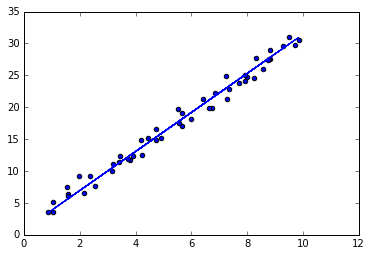

In [60]:
def params_search():
    """2d scan for possible values and return best ones
    """
    errors = []
    params = []
    for p0 in np.linspace(0,10):
        for p1 in np.linspace(0,10):
            p = (p0,p1)
            c = cost(x, y, linear_hypothesis, p)
            errors.append(c)
            params.append(p)
    return params[errors.index(min(errors))]

best = params_search()
print "Paramètres optimisant les moindres carrés :", best
plt.scatter(x,y)
plt.plot(x,best[0]+best[1]*x)
plt.show()

#### Recherche aléatoire de paramètres

Paramètres optimisant les moindres carrés : (2.4294762943890946, 2.7454069624650304)


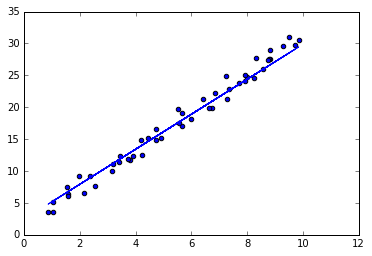

In [61]:
def random_params_search():
    errors = []
    params = []
    #choix arbitraire de recherche entre 0 et 5
    for p in 5*np.random.rand(100,2):
        p = tuple(p) 
        c = cost(x,y, linear, p)
        errors.append(c)
        params.append(p)
    return params[errors.index(min(errors))]

best = random_params_search()
print "Paramètres optimisant les moindres carrés :", best
plt.scatter(x,y)
plt.plot(x,best[0]+best[1]*x)
plt.show()

On peut chercher longtemps, surtout si l'on n'a pas une bonne idée des valeurs des paramètres que l'on cherche.

Les problèmes de recherche d'optimum et de racines de fonction sont particulièrement courants. De nombreuses méthodes existent, qui dépassent le cadre de ce cours.

## Descente de gradient

On démarre avec des paramètres $\theta_i$ aléatoires.

Plutôt que de tester de nouvelles combinaisons au hasard, nous allons mettre à jour les valeurs que nous avons en ajoutant ou soustrayant une certaine quantité dans la direction qui minimise l'erreur.

$\theta_{i+1} = \theta_i + \delta$

Si Erreur croît, alors sa dérivée est positive, et si elle décroit, alors elle est négative. Nous voulons donc aller dans la direction des dérivées décroissantes.

$$\delta \propto -\frac{\partial E}{\partial \theta_i}$$
<img src="img/2000px-Gradient_descent.svg.png" width="500">

Le gradient vient de la forme vectorielle.


In [74]:
def gradient_descent(x, y, start_params, alpha=0.00001, iterations=1000):
    start_params = list(start_params)
    N=len(y)
    error_history = np.array([]).reshape(0,3)
    
    for i in range(iterations):
        start_params[0] = start_params[0]-(alpha/N)*sum(linear_hypothesis(x,start_params)-y)
        start_params[1] = start_params[1]-(alpha/N)*(linear_hypothesis(x,start_params)-y).dot(x)
        error_history = np.vstack([error_history,
                                   [cost(x,y, linear, tuple(start_params)), 
                                    start_params[0], start_params[1]]])
        #print start_params
    return start_params, error_history    

In [75]:
p, error_history = gradient_descent(x, y, (5,10), alpha=0.01, iterations=10000)
print p

[1.3539879046164518, 2.9721257438441406]


Vérifions maintenant notre regression, l'évolution de l'erreur ainsi que des paramètres pendant la descente.

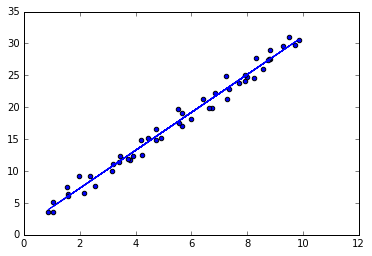

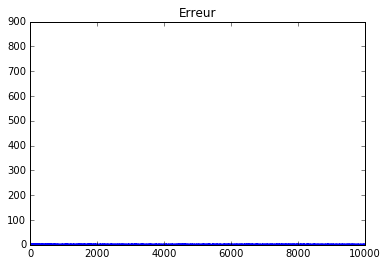

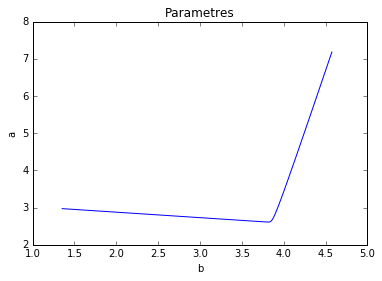

In [66]:
plt.scatter(x,y)
plt.plot(x,p[0]+p[1]*x)
plt.figure()
#plt.ylim(ymax)
plt.plot(np.arange(len(error_history)), error_history[:,0])
plt.title("Erreur")
plt.figure()
plt.plot(error_history[:,1], error_history[:,2])
plt.title("Parametres")
plt.xlabel("b")
plt.ylabel("a")
plt.show()

Quelle différence y'a-t-il dans les résultats entre `alpha=0.01` et `alpha=0.001` ?   
Comment peut-on améliorer notre code ?

-----

On peut également utiliser les bibliothèques disponibles sous python.

Par exemple avec scipy :

In [67]:
from scipy.optimize import curve_fit
def func(x, a, b):
    return a*x + b

popt, pcov = curve_fit(func, x, y)

In [68]:
popt

array([ 2.97212575,  1.35398786])

Mais il existe également une fonction spécifique pour la regression linéaire.

In [69]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

print slope, intercept

2.97212574644 1.35398788698


Cette fonction renvoie notamment le coefficient de détermination

$$R^2 = 1-\frac{\sum_i ( y_i - \hat y_i )^2}{\sum_i (y_i - \bar y_i )^2}$$

qui varie entre 0 et 1, et donne une indication sur le degré d'adéquation entre le modèle linéaire et les données, 1 voulant dire que le modèle capture 100% des variations. 


In [70]:
r_value

0.99225019913882773

Pour en savoir, google est votre ami, mais cette vidéo peut également être utile

In [71]:
from IPython.display import YouTubeVideo
YouTubeVideo("lng4ZgConCM")

Il est également commun de faire un test statistique sur le résultat de la régression, avec comme hypothèse que les coefficients sont nuls.

La valeur p est la probabilité que la variable slope ait la valeur déduite des observations si ces dernières sont le résultat de l'hypothèse nulle, soit ici qu'il n'y ait pas de dépendance linéaire. 

On constate dans notre cas que celle-ci est très faible, et on peut donc rejeter l'hypothèse nulle.

Généralement, une valeur critique pour p est 0.05. Il y a beaucoup de choses à dire sur le sujet. Nous y reviendrons dans de prochaines séances.

In [72]:
p_value

3.8862119245709232e-45

Que se passe-t-il si on les erreurs deviennent très importantes ? 

Numpy et Scipy sont des bilbiothèques dédiées à l'analyse numérique, et à la manipulation de vecteurs et de matrices, ainsi que la résolution de problèmes liés.

Des bibliothèques plus haut niveau (qui reposent notamment sur Numpy), sont plus spécialement dédiées à l'analyse et au mining de données.

* [statsmodel](http://statsmodels.sourceforge.net/), qui est orienté analyse statistique
* [scikit-learn](http://scikit-learn.org/stable/), qui est une bibliothèque de machine learning

## Résolution analytique pour les coefficients de la régression linéaire

$$\hat  \theta_1 = \frac{\sum(x_i-\bar x)(y_i-\bar y)}{\sum (x_i - \bar x)^2} = \frac{cov(x,y)}{var(x)}$$
$$\hat \theta_0 = \bar y - \hat \theta_1 \bar x$$

In [76]:
def moyenne(x):
    pass

def produit_scalaire(x,y):
    pass 

def variance(x):
    pass

def covariance(x,y):
    pass
    
def linear_parameters(x,y):
    pass